In [1]:
from torch.utils.data import DataLoader, random_split
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np

import warnings
import torch
import os

warnings.filterwarnings("ignore")
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

True
Device used: cuda


# Image Classification

For this last assignment, you will use PyTorch to implement a convolutional neural network image classifier. You will walk through the steps of setting up data, implementing training and validation code, specifying parameters, and learning and evaluating a model.

First, we will need to import the Imagenette data. In order to run it, download both `imagenette_train.pt` and `imagenett_test.pt` from the shared Google Drive [link](https://drive.google.com/drive/folders/1K8wD1dhGJ2ULG8KoBjDs6uzh5UwmfNw-?usp=sharing). Then, when you have saved them to a directory in your own Google Drive, run the function `import_imagenette_data()`, calling `/content/drive/MyDrive/<DIR_NAME>/` as a parameter.

In [2]:
def import_imagenette_data(dir):

    print("Downloading Imagenette Data...", end=" ")
    train_data = torch.load(os.path.join(dir, "imagenette_train.pt"))
    test_data = torch.load(os.path.join(dir, "imagenette_test.pt"))
    print("Download Complete!")

    return train_data, test_data

In [3]:
BASE_DIR = "C:/Users/david/ai/ai-hw-6"
DIR_NAME = "data/"
FULL_DIR = os.path.join(BASE_DIR, DIR_NAME)
all_train_data, test_data = import_imagenette_data(FULL_DIR)

# Task 1: `CNN` Class (8 points)

Our first task will be to write a class that stores a convolutional neural network model. Write the `__init__()` function. It should define two `nn.Sequential` attributes: `self.conv` and `self.fc`. `self.conv` should be a convolutional sequence; `self.fc` should be a simple multi-layer perceptron.

* The first layer of `self.conv` is a 2D convolutional layer that takes the specified number of in-channels, 16 out-channels, a kernel size of 8, and a stride length of 4. Follow this with a rectified linear unit, and then a 2D max pooling layer with kernel size 2 and stride length 2. Finally, repeat these three layers, but this time change the convolutional layer to have 16 in-channels, 32 out-channels, a kernel size of 4, and a stride length of 2. In the end, ```self.conv``` should have a total of 6 ```nn.Module``` objects.

* `self.fc` should consist of a flattening layer to flatten the output of `self.conv`. Then add a linear layer, a rectified linear unit, a linear layer, a rectified linear unit, and one final linear layer. The input dimension of `self.fc` should be the same as the output dimension of `self.conv`. The output dimension of `self.fc` should be the number of classes. For all other intermediate input/output dimensions, fix them to any number you'd like (we recommend anything above 256). In the end, ```self.fc``` should have 6 ```nn.Module``` objects.

* Be sure to call `super()` so that `CNN` can access methods form `nn.Module`.

* Be sure to send each of the constructed sequences to the specified device.

In [4]:
class CNN(nn.Module):
    def __init__(
            self,
            in_channels,
            num_classes,
            device,
    ):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ).to(device)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 6 * 6, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        ).to(device)
        
        
    def forward(
            self,
            x,
    ):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Task 2: Data and Learning Setup (12 points)

At the beginning, we imported two datasets: ```all_train_data``` and ```test_data```. When training a model, we want to train the model parameters on a _subset_ of the training data, and use the remaining training data to _validate_ and generalize the model.

* Use ```random_split()``` to separate ```all_train_data``` into a training dataset and a validation dataset. The training dataset should contain 80\% of the original training data, while the other 20\% should belong to the validation dataset.

* Store the training data, validation data, and test data in three separate `DataLoader` objects. Specify a batch size of 32.

*  Print out the number of data points in each of the three datasets (training, validation, and test datasets).

In [5]:
train_size = int(0.8 * len(all_train_data))
val_size = len(all_train_data) - train_size
train_data, val_data = random_split(all_train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

print(f"Number of data points in the training dataset: {len(train_data)}")
print(f"Number of data points in the validation dataset: {len(val_data)}")
print(f"Number of data points in the test dataset: {len(test_data)}")


Number of data points in the training dataset: 7282
Number of data points in the validation dataset: 1821
Number of data points in the test dataset: 3925


In order to train and evaluate our model, we need an optimizer and a criterion. For the former, we will use a procedure called [Adam](https://arxiv.org/abs/1412.6980) (ADAptive Moment estimation). Adam works similarly to stochastic gradient descent, except it _adapts_ its step size according to _momentum_, which is a measure of how close it is to a local minimum.

For the criterion, we will use cross-entropy loss, which just corresponds to the log loss that we saw in class for logistic regression.

* First initialize your CNN model, setting the number of input channels to 3 (one for each color channel), the number of classes to 10, and the device to the device you are currently using.

* Initialize an optimizer variable using the Adam optimizer from the PyTorch library. Set the learning rate to $1 \times 10^{-4}$.

* Initialize a criterion variable using the cross-entropy loss criterion from the PyTorch library.

In [6]:
model = CNN(3, 10, device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Task 3: `train()` Function (16 points)

Now we will implement ```train()```, the main function that will iterate through our data to learn the model. It takes in 7 parameters:

1. ```train_data```: this is a DataLoader object containing the training data.
2. ```val_data```: this is a DataLoader object containing the validation data.
3. ```model```: this is the CNN model that you instantiated to be trained.
4. ```criterion```: this is the criterion to be used during training.
5. ```optimizer```: this is the optimizer to be used during training.
6. ```num_epochs```: this is the number of epochs to train for.
7. ```device```: this is the device to send all computations to.

To train, you will iterate over the specified number of epochs. In each epoch, you will execute the training phase by iterating through the DataLoaders, calculating losses, and computing gradient update steps. You will then repeat these steps for the validation phase, but without the step of computing gradients and updating the model.

Within this function, you should also update the defined `info` dictionary. It contains four lists, updated at the end of each epoch: `"train_losses"`, `"train_accuracies"`, `"val_losses"`, `"val_accuracies"`. Return this dictionary when this function completes.

In [7]:
def train(
        train_data,
        val_data,
        model,
        criterion,
        optimizer,
        num_epochs,
        device,
):
    info = defaultdict(list)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_data):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        info["train_losses"].append(train_loss / len(train_data))
        info["train_accuracies"].append(train_correct / train_total)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_data):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        info["val_losses"].append(val_loss / len(val_data))
        info["val_accuracies"].append(val_correct / val_total)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {info['train_losses'][-1]:.4f}, Train Accuracy: {info['train_accuracies'][-1]:.4f}")
        print(f"Val Loss: {info['val_losses'][-1]:.4f}, Val Accuracy: {info['val_accuracies'][-1]:.4f}")

    return info


Once you have this function implemented, call it to train the model with all of our defined parameters. Use 50 epochs.

In [8]:
info = train(train_loader, val_loader, model, criterion, optimizer, 50, device)

100%|██████████| 57/57 [00:00<00:00, 104.10it/s]


Epoch 1/50:
Train Loss: 2.1313, Train Accuracy: 0.2388
Val Loss: 2.0038, Val Accuracy: 0.2987


100%|██████████| 57/57 [00:00<00:00, 99.95it/s] 


Epoch 2/50:
Train Loss: 1.8807, Train Accuracy: 0.3489
Val Loss: 1.8102, Val Accuracy: 0.3992


100%|██████████| 57/57 [00:00<00:00, 97.24it/s]


Epoch 3/50:
Train Loss: 1.7618, Train Accuracy: 0.3958
Val Loss: 1.7798, Val Accuracy: 0.3882


100%|██████████| 57/57 [00:00<00:00, 92.22it/s]


Epoch 4/50:
Train Loss: 1.6767, Train Accuracy: 0.4239
Val Loss: 1.7126, Val Accuracy: 0.4267


100%|██████████| 57/57 [00:00<00:00, 102.91it/s]


Epoch 5/50:
Train Loss: 1.5773, Train Accuracy: 0.4591
Val Loss: 1.6172, Val Accuracy: 0.4498


100%|██████████| 57/57 [00:00<00:00, 98.42it/s]


Epoch 6/50:
Train Loss: 1.5071, Train Accuracy: 0.4813
Val Loss: 1.5738, Val Accuracy: 0.4646


100%|██████████| 57/57 [00:00<00:00, 103.67it/s]


Epoch 7/50:
Train Loss: 1.4502, Train Accuracy: 0.5033
Val Loss: 1.5124, Val Accuracy: 0.4843


100%|██████████| 57/57 [00:00<00:00, 104.45it/s]


Epoch 8/50:
Train Loss: 1.3832, Train Accuracy: 0.5323
Val Loss: 1.5119, Val Accuracy: 0.4915


100%|██████████| 57/57 [00:00<00:00, 99.99it/s] 


Epoch 9/50:
Train Loss: 1.3170, Train Accuracy: 0.5597
Val Loss: 1.4629, Val Accuracy: 0.4986


100%|██████████| 57/57 [00:00<00:00, 98.78it/s]


Epoch 10/50:
Train Loss: 1.2737, Train Accuracy: 0.5718
Val Loss: 1.4576, Val Accuracy: 0.5200


100%|██████████| 57/57 [00:00<00:00, 100.56it/s]


Epoch 11/50:
Train Loss: 1.2199, Train Accuracy: 0.5934
Val Loss: 1.3809, Val Accuracy: 0.5299


100%|██████████| 57/57 [00:00<00:00, 99.60it/s] 


Epoch 12/50:
Train Loss: 1.1805, Train Accuracy: 0.6007
Val Loss: 1.3784, Val Accuracy: 0.5327


100%|██████████| 57/57 [00:00<00:00, 97.98it/s] 


Epoch 13/50:
Train Loss: 1.1233, Train Accuracy: 0.6254
Val Loss: 1.3464, Val Accuracy: 0.5508


100%|██████████| 57/57 [00:00<00:00, 98.37it/s]


Epoch 14/50:
Train Loss: 1.0922, Train Accuracy: 0.6362
Val Loss: 1.3332, Val Accuracy: 0.5481


100%|██████████| 57/57 [00:00<00:00, 102.43it/s]


Epoch 15/50:
Train Loss: 1.0379, Train Accuracy: 0.6568
Val Loss: 1.3125, Val Accuracy: 0.5634


100%|██████████| 57/57 [00:00<00:00, 90.79it/s]


Epoch 16/50:
Train Loss: 0.9923, Train Accuracy: 0.6747
Val Loss: 1.3062, Val Accuracy: 0.5728


100%|██████████| 57/57 [00:00<00:00, 93.94it/s]


Epoch 17/50:
Train Loss: 0.9482, Train Accuracy: 0.6870
Val Loss: 1.3537, Val Accuracy: 0.5502


100%|██████████| 57/57 [00:00<00:00, 98.43it/s]


Epoch 18/50:
Train Loss: 0.9092, Train Accuracy: 0.7001
Val Loss: 1.2832, Val Accuracy: 0.5706


100%|██████████| 57/57 [00:00<00:00, 104.40it/s]


Epoch 19/50:
Train Loss: 0.8603, Train Accuracy: 0.7175
Val Loss: 1.3490, Val Accuracy: 0.5695


100%|██████████| 57/57 [00:00<00:00, 108.82it/s]


Epoch 20/50:
Train Loss: 0.8158, Train Accuracy: 0.7336
Val Loss: 1.3301, Val Accuracy: 0.5695


100%|██████████| 57/57 [00:00<00:00, 105.39it/s]


Epoch 21/50:
Train Loss: 0.7751, Train Accuracy: 0.7443
Val Loss: 1.3163, Val Accuracy: 0.5667


100%|██████████| 57/57 [00:00<00:00, 106.64it/s]


Epoch 22/50:
Train Loss: 0.7376, Train Accuracy: 0.7608
Val Loss: 1.3435, Val Accuracy: 0.5733


100%|██████████| 57/57 [00:00<00:00, 100.12it/s]


Epoch 23/50:
Train Loss: 0.6971, Train Accuracy: 0.7781
Val Loss: 1.3751, Val Accuracy: 0.5717


100%|██████████| 57/57 [00:00<00:00, 107.00it/s]


Epoch 24/50:
Train Loss: 0.6531, Train Accuracy: 0.7895
Val Loss: 1.3332, Val Accuracy: 0.5887


100%|██████████| 57/57 [00:00<00:00, 105.74it/s]


Epoch 25/50:
Train Loss: 0.6008, Train Accuracy: 0.8105
Val Loss: 1.3528, Val Accuracy: 0.5887


100%|██████████| 57/57 [00:00<00:00, 109.75it/s]


Epoch 26/50:
Train Loss: 0.5543, Train Accuracy: 0.8245
Val Loss: 1.4385, Val Accuracy: 0.5684


100%|██████████| 57/57 [00:00<00:00, 103.19it/s]


Epoch 27/50:
Train Loss: 0.5226, Train Accuracy: 0.8406
Val Loss: 1.4245, Val Accuracy: 0.5722


100%|██████████| 57/57 [00:00<00:00, 106.17it/s]


Epoch 28/50:
Train Loss: 0.4808, Train Accuracy: 0.8507
Val Loss: 1.4402, Val Accuracy: 0.5821


100%|██████████| 57/57 [00:00<00:00, 106.34it/s]


Epoch 29/50:
Train Loss: 0.4243, Train Accuracy: 0.8776
Val Loss: 1.4992, Val Accuracy: 0.5750


100%|██████████| 57/57 [00:00<00:00, 98.90it/s] 


Epoch 30/50:
Train Loss: 0.3921, Train Accuracy: 0.8863
Val Loss: 1.5380, Val Accuracy: 0.5755


100%|██████████| 57/57 [00:00<00:00, 94.06it/s]


Epoch 31/50:
Train Loss: 0.3409, Train Accuracy: 0.9030
Val Loss: 1.5591, Val Accuracy: 0.5722


100%|██████████| 57/57 [00:00<00:00, 92.96it/s]


Epoch 32/50:
Train Loss: 0.3088, Train Accuracy: 0.9140
Val Loss: 1.5927, Val Accuracy: 0.5794


100%|██████████| 57/57 [00:00<00:00, 99.73it/s] 


Epoch 33/50:
Train Loss: 0.2718, Train Accuracy: 0.9265
Val Loss: 1.7438, Val Accuracy: 0.5530


100%|██████████| 57/57 [00:00<00:00, 102.02it/s]


Epoch 34/50:
Train Loss: 0.2282, Train Accuracy: 0.9460
Val Loss: 1.6734, Val Accuracy: 0.5788


100%|██████████| 57/57 [00:00<00:00, 87.52it/s]


Epoch 35/50:
Train Loss: 0.2035, Train Accuracy: 0.9508
Val Loss: 1.8448, Val Accuracy: 0.5596


100%|██████████| 57/57 [00:00<00:00, 100.72it/s]


Epoch 36/50:
Train Loss: 0.1734, Train Accuracy: 0.9606
Val Loss: 1.8767, Val Accuracy: 0.5574


100%|██████████| 57/57 [00:00<00:00, 93.83it/s]


Epoch 37/50:
Train Loss: 0.1454, Train Accuracy: 0.9728
Val Loss: 1.8651, Val Accuracy: 0.5739


100%|██████████| 57/57 [00:00<00:00, 103.32it/s]


Epoch 38/50:
Train Loss: 0.1196, Train Accuracy: 0.9756
Val Loss: 1.9229, Val Accuracy: 0.5815


100%|██████████| 57/57 [00:00<00:00, 103.07it/s]


Epoch 39/50:
Train Loss: 0.1008, Train Accuracy: 0.9815
Val Loss: 2.0386, Val Accuracy: 0.5684


100%|██████████| 57/57 [00:00<00:00, 104.09it/s]


Epoch 40/50:
Train Loss: 0.0868, Train Accuracy: 0.9857
Val Loss: 2.0756, Val Accuracy: 0.5645


100%|██████████| 57/57 [00:00<00:00, 107.75it/s]


Epoch 41/50:
Train Loss: 0.0692, Train Accuracy: 0.9896
Val Loss: 2.1391, Val Accuracy: 0.5706


100%|██████████| 57/57 [00:00<00:00, 100.21it/s]


Epoch 42/50:
Train Loss: 0.0678, Train Accuracy: 0.9897
Val Loss: 2.1970, Val Accuracy: 0.5783


100%|██████████| 57/57 [00:00<00:00, 105.67it/s]


Epoch 43/50:
Train Loss: 0.0485, Train Accuracy: 0.9956
Val Loss: 2.2507, Val Accuracy: 0.5755


100%|██████████| 57/57 [00:00<00:00, 81.35it/s]


Epoch 44/50:
Train Loss: 0.0327, Train Accuracy: 0.9973
Val Loss: 2.3520, Val Accuracy: 0.5667


100%|██████████| 57/57 [00:00<00:00, 83.10it/s] 


Epoch 45/50:
Train Loss: 0.0310, Train Accuracy: 0.9968
Val Loss: 2.4303, Val Accuracy: 0.5739


100%|██████████| 57/57 [00:00<00:00, 108.02it/s]


Epoch 46/50:
Train Loss: 0.0266, Train Accuracy: 0.9981
Val Loss: 2.3926, Val Accuracy: 0.5826


100%|██████████| 57/57 [00:00<00:00, 106.32it/s]


Epoch 47/50:
Train Loss: 0.0239, Train Accuracy: 0.9978
Val Loss: 2.5224, Val Accuracy: 0.5717


100%|██████████| 57/57 [00:00<00:00, 81.11it/s]


Epoch 48/50:
Train Loss: 0.0189, Train Accuracy: 0.9986
Val Loss: 2.6141, Val Accuracy: 0.5733


100%|██████████| 57/57 [00:00<00:00, 92.72it/s]


Epoch 49/50:
Train Loss: 0.0122, Train Accuracy: 0.9999
Val Loss: 2.7203, Val Accuracy: 0.5722


100%|██████████| 57/57 [00:00<00:00, 92.85it/s]


Epoch 50/50:
Train Loss: 0.0968, Train Accuracy: 0.9668
Val Loss: 2.5365, Val Accuracy: 0.5475


In [9]:
#save model
dir = os.path.join(BASE_DIR, "models/")
torch.save(model.state_dict(), os.path.join(dir, "model.pth"))

# Task 4: Loss and Accuracy Curves (8 points)

Use the ```plot_info()``` function below to plot the training and validation losses and accuracies in `info`. Then briefly answer the following questions.

* Give a qualitative description of the training and validation loss curves. What do you notice about the loss curves in relation to each other?

* Let's focus on the validation loss and accuracy curves. Around how many epochs does the model begin to overfit? What do the loss and accuracy curves look like when this happens?

* Let's zoom in once more on the validation loss curve only. How does this curve inform you on when your model has the best performance without overfitting the training data?

In [10]:
def plot_info(info):
    fig, ax = plt.axes = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(info["train_losses"], label="Train Loss")
    ax[0].plot(info["val_losses"], label="Validation Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Loss vs. Epochs")
    ax[0].legend()
    ax[1].plot(info["train_accuracies"], label="Train Accuracy")
    ax[1].plot(info["val_accuracies"], label="Validation Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy vs. Epochs")
    ax[1].legend()
    plt.show()

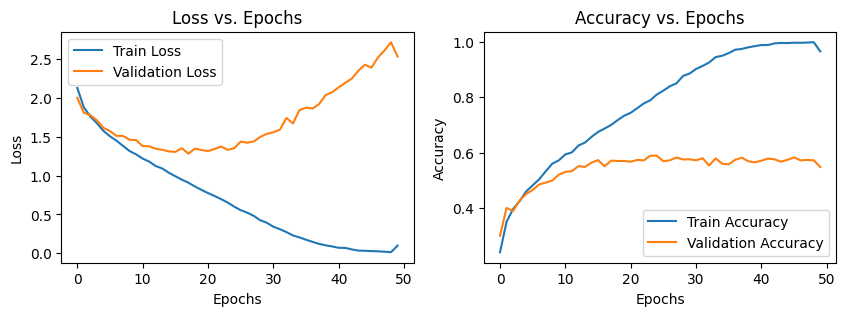

In [11]:
plot_info(info)


* Give a qualitative description of the training and validation loss curves. What do you notice about the loss curves in relation to each other?

I notice that the training loss continues to decrease as the number of epochs increases, while the validation loss begins to increase after around 20 epochs. This suggests that the model is overfitting the training data after around 20 epochs.

* Let's focus on the validation loss and accuracy curves. Around how many epochs does the model begin to overfit? What do the loss and accuracy curves look like when this happens?

The model begins to overfit around 20 epochs. The validation loss begins to increase, while the validation accuracy mostly stays the same.

* Let's zoom in once more on the validation loss curve only. How does this curve inform you on when your model has the best performance without overfitting the training data?

The validation loss curve informs me that the model has the best performance without overfitting the training data around 20 epochs. This is because the validation loss is at its lowest point around this time.

# Task 5: `test()` Function (8 points)

The last task in most learning tasks is to obtain a final evaluation of a model's performance on test data. Implement the `test()` function below, which takes a (test) dataset and model. It should then perform prediction on each data instance and compute and return the overall accuracy. Its implementation should be relatively similar to that of `train()`.

In [15]:
def test(test_data, model):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_data):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    print(f"Test Loss: {test_loss / len(test_data):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

    return test_loss, test_correct, test_total

# Task 6: Model Comparison (8 points)

Let's retrieve the "best" model from the training procedure and compare it against the "last" one that we obtain after 50 epochs. Modify the `train()` from Part 3 to include the following:

* Save the model with the lowest validation loss to ```best_model.pth``` using `torch.save()`. You can do this by comparing each epoch's loss to the lowest one seen so far, and overriding the previous best model with the current one if you see a lower loss.

* Save the model at the end of the training loop to ```last_model.pth```.

After making these additions, instantiate a new model, train it using the same parameters as Task 3, and save your best and last models. Then, evaluate both models on the testing data using your `test()` function. Print the accuracies returned by each.

In [16]:
def train(
        train_data,
        val_data,
        model,
        criterion,
        optimizer,
        num_epochs,
        device,
):
    info = defaultdict(list)
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_data):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        info["train_losses"].append(train_loss / len(train_data))
        info["train_accuracies"].append(train_correct / train_total)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_data):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        info["val_losses"].append(val_loss / len(val_data))
        info["val_accuracies"].append(val_correct / val_total)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(dir, "best_model.pth"))

        torch.save(model.state_dict(), os.path.join(dir, "last_model.pth"))

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {info['train_losses'][-1]:.4f}, Train Accuracy: {info['train_accuracies'][-1]:.4f}")
        print(f"Val Loss: {info['val_losses'][-1]:.4f}, Val Accuracy: {info['val_accuracies'][-1]:.4f}")

    return info

model = CNN(3, 10, device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
info = train(train_loader, val_loader, model, criterion, optimizer, 50, device)

best_model = CNN(3, 10, device)
best_model.load_state_dict(torch.load(os.path.join(dir, "best_model.pth")))
best_model.to(device)
test(test_loader, best_model)

last_model = CNN(3, 10, device)
last_model.load_state_dict(torch.load(os.path.join(dir, "last_model.pth")))
last_model.to(device)
test(test_loader, last_model)


100%|██████████| 57/57 [00:00<00:00, 109.45it/s]


Epoch 1/50:
Train Loss: 2.1565, Train Accuracy: 0.2326
Val Loss: 1.9430, Val Accuracy: 0.3498


100%|██████████| 57/57 [00:00<00:00, 98.53it/s]


Epoch 2/50:
Train Loss: 1.8611, Train Accuracy: 0.3577
Val Loss: 1.8347, Val Accuracy: 0.3778


100%|██████████| 57/57 [00:00<00:00, 99.87it/s] 


Epoch 3/50:
Train Loss: 1.7249, Train Accuracy: 0.4065
Val Loss: 1.7076, Val Accuracy: 0.4206


100%|██████████| 57/57 [00:00<00:00, 103.52it/s]


Epoch 4/50:
Train Loss: 1.6266, Train Accuracy: 0.4404
Val Loss: 1.6601, Val Accuracy: 0.4355


100%|██████████| 57/57 [00:00<00:00, 105.56it/s]


Epoch 5/50:
Train Loss: 1.5403, Train Accuracy: 0.4738
Val Loss: 1.5612, Val Accuracy: 0.4695


100%|██████████| 57/57 [00:00<00:00, 96.95it/s] 


Epoch 6/50:
Train Loss: 1.4475, Train Accuracy: 0.5147
Val Loss: 1.5361, Val Accuracy: 0.4717


100%|██████████| 57/57 [00:00<00:00, 105.87it/s]


Epoch 7/50:
Train Loss: 1.3762, Train Accuracy: 0.5372
Val Loss: 1.4801, Val Accuracy: 0.5014


100%|██████████| 57/57 [00:00<00:00, 102.50it/s]


Epoch 8/50:
Train Loss: 1.3180, Train Accuracy: 0.5571
Val Loss: 1.4483, Val Accuracy: 0.5052


100%|██████████| 57/57 [00:00<00:00, 104.94it/s]


Epoch 9/50:
Train Loss: 1.2644, Train Accuracy: 0.5762
Val Loss: 1.4237, Val Accuracy: 0.5261


100%|██████████| 57/57 [00:00<00:00, 90.00it/s]


Epoch 10/50:
Train Loss: 1.2154, Train Accuracy: 0.5965
Val Loss: 1.4527, Val Accuracy: 0.5178


100%|██████████| 57/57 [00:00<00:00, 95.06it/s] 


Epoch 11/50:
Train Loss: 1.1698, Train Accuracy: 0.6101
Val Loss: 1.3535, Val Accuracy: 0.5535


100%|██████████| 57/57 [00:00<00:00, 87.01it/s]


Epoch 12/50:
Train Loss: 1.1379, Train Accuracy: 0.6299
Val Loss: 1.3531, Val Accuracy: 0.5590


100%|██████████| 57/57 [00:00<00:00, 103.62it/s]


Epoch 13/50:
Train Loss: 1.0983, Train Accuracy: 0.6419
Val Loss: 1.3650, Val Accuracy: 0.5590


100%|██████████| 57/57 [00:00<00:00, 103.60it/s]


Epoch 14/50:
Train Loss: 1.0591, Train Accuracy: 0.6511
Val Loss: 1.3246, Val Accuracy: 0.5612


100%|██████████| 57/57 [00:00<00:00, 100.87it/s]


Epoch 15/50:
Train Loss: 1.0311, Train Accuracy: 0.6611
Val Loss: 1.3313, Val Accuracy: 0.5596


100%|██████████| 57/57 [00:00<00:00, 108.47it/s]


Epoch 16/50:
Train Loss: 0.9854, Train Accuracy: 0.6785
Val Loss: 1.3420, Val Accuracy: 0.5535


100%|██████████| 57/57 [00:00<00:00, 101.42it/s]


Epoch 17/50:
Train Loss: 0.9532, Train Accuracy: 0.6858
Val Loss: 1.3353, Val Accuracy: 0.5574


100%|██████████| 57/57 [00:00<00:00, 95.06it/s] 


Epoch 18/50:
Train Loss: 0.9044, Train Accuracy: 0.6994
Val Loss: 1.3486, Val Accuracy: 0.5684


100%|██████████| 57/57 [00:00<00:00, 99.54it/s] 


Epoch 19/50:
Train Loss: 0.8728, Train Accuracy: 0.7210
Val Loss: 1.2688, Val Accuracy: 0.5870


100%|██████████| 57/57 [00:00<00:00, 100.91it/s]


Epoch 20/50:
Train Loss: 0.8315, Train Accuracy: 0.7270
Val Loss: 1.3380, Val Accuracy: 0.5678


100%|██████████| 57/57 [00:00<00:00, 103.62it/s]


Epoch 21/50:
Train Loss: 0.7926, Train Accuracy: 0.7400
Val Loss: 1.3076, Val Accuracy: 0.5805


100%|██████████| 57/57 [00:00<00:00, 105.21it/s]


Epoch 22/50:
Train Loss: 0.7422, Train Accuracy: 0.7593
Val Loss: 1.2923, Val Accuracy: 0.5881


100%|██████████| 57/57 [00:00<00:00, 103.70it/s]


Epoch 23/50:
Train Loss: 0.7075, Train Accuracy: 0.7763
Val Loss: 1.2996, Val Accuracy: 0.5931


100%|██████████| 57/57 [00:00<00:00, 100.64it/s]


Epoch 24/50:
Train Loss: 0.6632, Train Accuracy: 0.7852
Val Loss: 1.3119, Val Accuracy: 0.6019


100%|██████████| 57/57 [00:00<00:00, 104.54it/s]


Epoch 25/50:
Train Loss: 0.6139, Train Accuracy: 0.8073
Val Loss: 1.3141, Val Accuracy: 0.5958


100%|██████████| 57/57 [00:00<00:00, 84.10it/s]


Epoch 26/50:
Train Loss: 0.5792, Train Accuracy: 0.8154
Val Loss: 1.3766, Val Accuracy: 0.5865


100%|██████████| 57/57 [00:00<00:00, 104.64it/s]


Epoch 27/50:
Train Loss: 0.5300, Train Accuracy: 0.8351
Val Loss: 1.4338, Val Accuracy: 0.5788


100%|██████████| 57/57 [00:00<00:00, 93.55it/s]


Epoch 28/50:
Train Loss: 0.4926, Train Accuracy: 0.8488
Val Loss: 1.4124, Val Accuracy: 0.5903


100%|██████████| 57/57 [00:00<00:00, 100.02it/s]


Epoch 29/50:
Train Loss: 0.4497, Train Accuracy: 0.8661
Val Loss: 1.4526, Val Accuracy: 0.5766


100%|██████████| 57/57 [00:00<00:00, 73.36it/s]


Epoch 30/50:
Train Loss: 0.4125, Train Accuracy: 0.8757
Val Loss: 1.4529, Val Accuracy: 0.5859


100%|██████████| 57/57 [00:00<00:00, 106.31it/s]


Epoch 31/50:
Train Loss: 0.3775, Train Accuracy: 0.8886
Val Loss: 1.5200, Val Accuracy: 0.5755


100%|██████████| 57/57 [00:00<00:00, 103.74it/s]


Epoch 32/50:
Train Loss: 0.3326, Train Accuracy: 0.9028
Val Loss: 1.5009, Val Accuracy: 0.5865


100%|██████████| 57/57 [00:00<00:00, 101.14it/s]


Epoch 33/50:
Train Loss: 0.2948, Train Accuracy: 0.9179
Val Loss: 1.5900, Val Accuracy: 0.5843


100%|██████████| 57/57 [00:00<00:00, 109.93it/s]


Epoch 34/50:
Train Loss: 0.2685, Train Accuracy: 0.9282
Val Loss: 1.5862, Val Accuracy: 0.5832


100%|██████████| 57/57 [00:00<00:00, 108.39it/s]


Epoch 35/50:
Train Loss: 0.2281, Train Accuracy: 0.9423
Val Loss: 1.6450, Val Accuracy: 0.5799


100%|██████████| 57/57 [00:00<00:00, 106.75it/s]


Epoch 36/50:
Train Loss: 0.2015, Train Accuracy: 0.9514
Val Loss: 1.6509, Val Accuracy: 0.5903


100%|██████████| 57/57 [00:00<00:00, 92.73it/s]


Epoch 37/50:
Train Loss: 0.1687, Train Accuracy: 0.9632
Val Loss: 1.7408, Val Accuracy: 0.5898


100%|██████████| 57/57 [00:00<00:00, 104.94it/s]


Epoch 38/50:
Train Loss: 0.1487, Train Accuracy: 0.9670
Val Loss: 1.8383, Val Accuracy: 0.5794


100%|██████████| 57/57 [00:00<00:00, 111.13it/s]


Epoch 39/50:
Train Loss: 0.1295, Train Accuracy: 0.9725
Val Loss: 1.8960, Val Accuracy: 0.5821


100%|██████████| 57/57 [00:00<00:00, 105.36it/s]


Epoch 40/50:
Train Loss: 0.1235, Train Accuracy: 0.9718
Val Loss: 1.9333, Val Accuracy: 0.5826


100%|██████████| 57/57 [00:00<00:00, 105.50it/s]


Epoch 41/50:
Train Loss: 0.0946, Train Accuracy: 0.9821
Val Loss: 2.0222, Val Accuracy: 0.5744


100%|██████████| 57/57 [00:00<00:00, 93.17it/s]


Epoch 42/50:
Train Loss: 0.0798, Train Accuracy: 0.9857
Val Loss: 2.0635, Val Accuracy: 0.5810


100%|██████████| 57/57 [00:00<00:00, 103.54it/s]


Epoch 43/50:
Train Loss: 0.0582, Train Accuracy: 0.9929
Val Loss: 2.1529, Val Accuracy: 0.5794


100%|██████████| 57/57 [00:00<00:00, 97.89it/s] 


Epoch 44/50:
Train Loss: 0.0514, Train Accuracy: 0.9931
Val Loss: 2.1694, Val Accuracy: 0.5772


100%|██████████| 57/57 [00:00<00:00, 103.13it/s]


Epoch 45/50:
Train Loss: 0.0442, Train Accuracy: 0.9948
Val Loss: 2.2470, Val Accuracy: 0.5848


100%|██████████| 57/57 [00:00<00:00, 101.05it/s]


Epoch 46/50:
Train Loss: 0.0367, Train Accuracy: 0.9960
Val Loss: 2.4322, Val Accuracy: 0.5684


100%|██████████| 57/57 [00:00<00:00, 96.74it/s]


Epoch 47/50:
Train Loss: 0.0359, Train Accuracy: 0.9953
Val Loss: 2.3961, Val Accuracy: 0.5777


100%|██████████| 57/57 [00:00<00:00, 96.56it/s]


Epoch 48/50:
Train Loss: 0.0348, Train Accuracy: 0.9960
Val Loss: 2.4237, Val Accuracy: 0.5755


100%|██████████| 57/57 [00:00<00:00, 98.07it/s] 


Epoch 49/50:
Train Loss: 0.0218, Train Accuracy: 0.9982
Val Loss: 2.6384, Val Accuracy: 0.5695


100%|██████████| 57/57 [00:00<00:00, 96.86it/s] 


Epoch 50/50:
Train Loss: 0.0609, Train Accuracy: 0.9846
Val Loss: 2.7895, Val Accuracy: 0.5453


100%|██████████| 123/123 [00:01<00:00, 100.72it/s]


Test Loss: 1.2805, Test Accuracy: 0.5880


100%|██████████| 123/123 [00:01<00:00, 93.94it/s]

Test Loss: 2.9269, Test Accuracy: 0.5460


(360.004970908165, 2143, 3925)

In [17]:
test(test_loader, best_model)
test(test_loader, last_model)


100%|██████████| 123/123 [00:01<00:00, 81.24it/s] 


Test Loss: 1.2771, Test Accuracy: 0.5880


100%|██████████| 123/123 [00:01<00:00, 101.51it/s]

Test Loss: 2.9318, Test Accuracy: 0.5460


(360.6171367764473, 2143, 3925)